In [1]:
%cd '../'

/mnt/md2/geoframework/models/rnd/happy_whale/model_test


In [43]:
import os
import random

from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.nn import functional as F
import torchmetrics.functional as M

import albumentations as A
from albumentations.pytorch import ToTensorV2

from trainer import TorchLightNet
from generator import MyDataset
from make_data_frame import make_data_frame
from settings import exp, csv_folder, check_pointer_path, sub_exp, AVAIL_GPUS

In [3]:
device = torch.device('cpu')

chk_path = os.path.join(
    '/home/misha/geoframework/models/rnd/happy_whale/check_points/1.1.5/'
    'epoch=11-val_loss=0.6487-val_acc=0.6381.ckpt'
    )
model = TorchLightNet.load_from_checkpoint(checkpoint_path=chk_path)
model.to(device)
model.eval()

dataset, df = make_data_frame(csv_folder,
                              'train_bbox_df.csv',
                              'validate_bbox_df.csv',
                              'test_bbox_df.csv')
test = df.get('test')

batch_size = 32
val_transform = A.Compose(
    [
        A.Resize(width=128, height=128),
        A.Normalize(mean=0, std=1),
        ToTensorV2(),
    ],
    additional_targets={'image_b': 'image'}
)

test_dataset = MyDataset(test, crop=True, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=6)

In [ ]:
labels_list = []
preds_list = []
logits_list = []
bi_preds_list = []

ims_a = []
ims_b = []

for idx, inputs, labels in tqdm(test_loader):
    im_a = inputs['first']
    im_b = inputs['second']
    
    im_a = im_a.to(device, dtype=torch.float)
    im_b = im_b.to(device, dtype=torch.float)
    labels = labels.to(device, dtype=torch.float)

    with torch.set_grad_enabled(False):
        preds = model({'first': im_a, 'second': im_b})
    
    logits = torch.sigmoid(preds)
    
    threshold = torch.tensor([0.5])
    threshold = threshold.to(device, dtype=torch.float)
    bi_preds = (logits > threshold).float() * 1
    acc = M.accuracy(bi_preds.int(), labels.int())
    
    labels_list.append(labels.data.cpu().numpy().flatten())
    preds_list.append(preds.data.cpu().numpy().flatten())
    logits_list.append(logits.data.cpu().numpy().flatten())
    bi_preds_list.append(bi_preds.data.cpu().numpy().flatten())

labels_array = np.concatenate(labels_list)
preds_array = np.concatenate(preds_list)
logits_array = np.concatenate(logits_list)
bi_preds_array = np.concatenate(bi_preds_list)

  5%|▍         | 31/623 [10:46<3:27:28, 21.03s/it]

In [ ]:
df_res = pd.DataFrame(data={
    'preds': preds_array,
    'logits': logits_array,
    'bi_preds': bi_preds_array
})
df_res = pd.concat([test, df_res], axis=1)

In [50]:
df_res_srtd = df_res[
    [
        'image_a', 'species', 'individual_id', 'image_b', 'image_a_id',
        'image_b_id', 'width_a', 'height_a', 'bbox_voc_a', 'bbox_voc_b', 'label_path_a',
        'width_b', 'height_b', 'preds', 'logits', 'bi_preds', 'label'
    ]
]
df_res_srtd.to_csv('df_res.csv', index=False)

In [51]:
df_id_count = df_res_srtd.groupby(['individual_id'])[['individual_id']].count().rename(
    columns={
        'individual_id': 'count'
    }
).sort_values('count')
df_id_count.reset_index(inplace=True)

single_ids = df_id_count[df_id_count['count'] == 1]['individual_id'].tolist()
top_ids = df_id_count[df_id_count['count'] >= 200]['individual_id'].tolist()

In [52]:
top_ids_df = df_res_srtd[df_res_srtd['individual_id'].isin(top_ids)].reset_index(drop=True)
labels_array = top_ids_df['label'].astype(float)
bi_preds_array = top_ids_df['bi_preds']

In [42]:
def quick_metrics(labels_array, bi_preds_array):

    precision, recall, f1, _ = precision_recall_fscore_support(labels_array,
                                                               bi_preds_array,
                                                               average='macro'  # cause we have balanced classes
                                                              )
    return print(f'precision is {round(precision, 2)}, recall is {round(recall, 2)}, f1 is {round(f1, 2)}')

In [35]:
metrics(labels_array, bi_preds_array)

precision is 0.48, recall is 0.5, f1 is 0.38


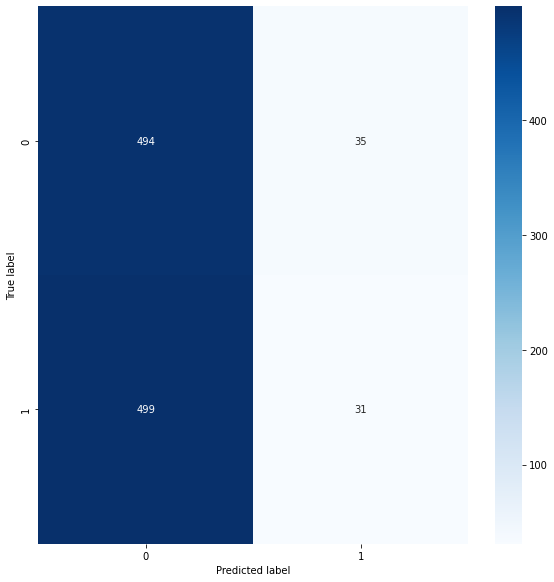

In [44]:
conf_matrix = metrics.confusion_matrix(labels_array, bi_preds_array) 
conf_matrix_df = pd.DataFrame(conf_matrix)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_df,
            annot=True,
            fmt='d',
            cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
def crop_image(row, image, image_name):
    if image_name == 'first':
        bbox = row['bbox_voc_a']
        xmin, ymin, xmax, ymax = bbox
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        image = image[ymin:ymax, xmin:xmax]
    else:
        bbox = row['bbox_voc_b']
        xmin, ymin, xmax, ymax = bbox
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        image = image[ymin:ymax, xmin:xmax]
    return image

def get_input(row):

    image_a = cv2.imread(row['image_a'])
    image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB)

    image_b = cv2.imread(row['image_b'])
    image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB)
    
    image_a = crop_image(row, image_a, 'first')
    image_b = crop_image(row, image_b, 'second')
    
    return image_a, image_b

In [56]:
row

image_a          /media/storage3/data3T/happy_whale/train_image...
species                                             humpback_whale
individual_id                                         6a3af6e0c55c
image_b          /media/storage3/data3T/happy_whale/train_image...
image_a_id                                          d20b8a4709ffcc
image_b_id                                          0557b40be94cf8
width_a                                                     3599.0
height_a                                                    2399.0
bbox_voc_a       [114.00012450000008, 906.0003425000002, 3447.0...
bbox_voc_b       [0.0018000000000029104, 1141.9992, 3594.000600...
label_path_a     /media/storage3/data3T/happy_whale/output/trai...
width_b                                                     3600.0
height_b                                                    2400.0
preds                                                     1.135152
logits                                                    0.75

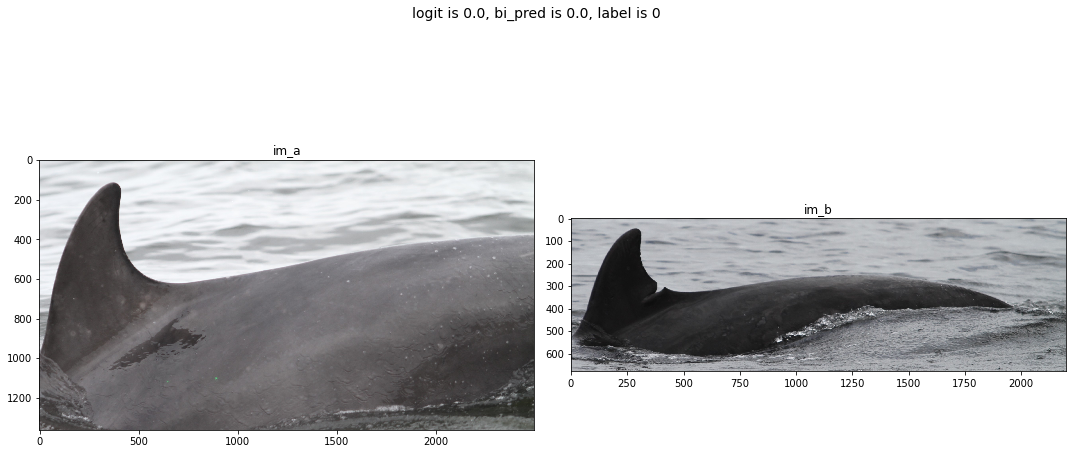

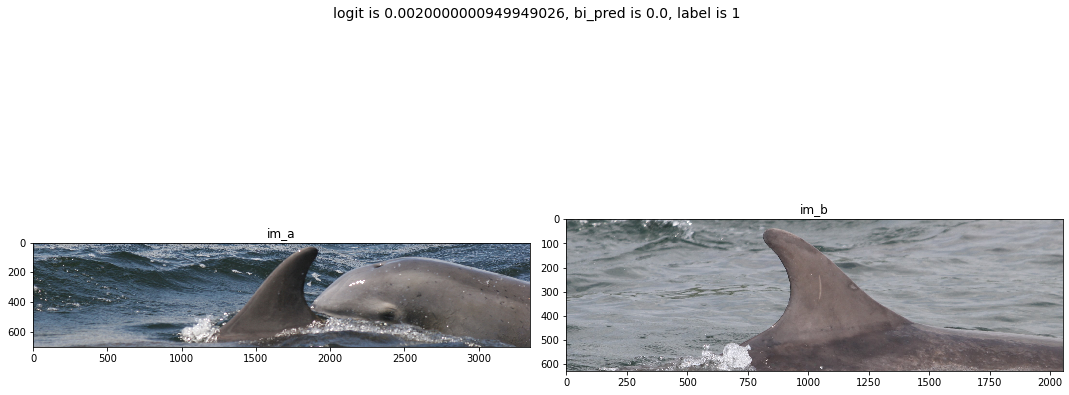

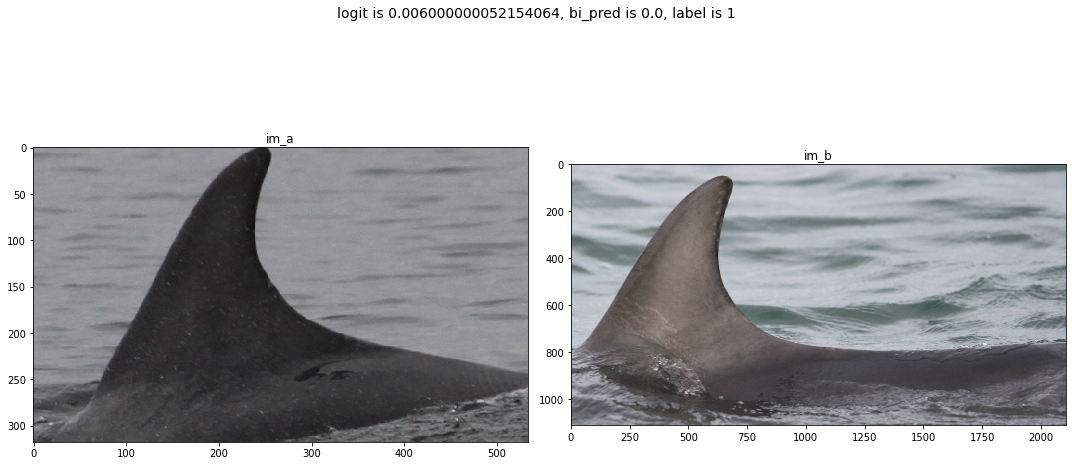

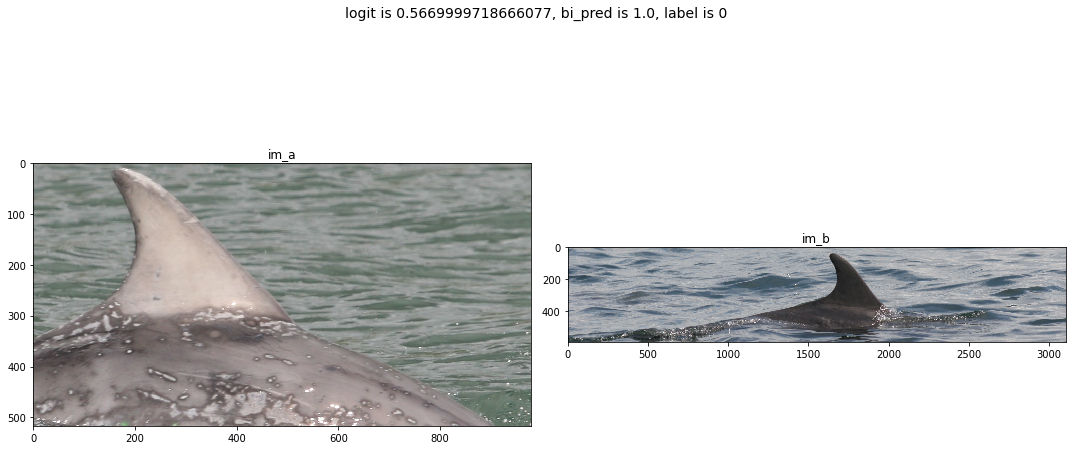

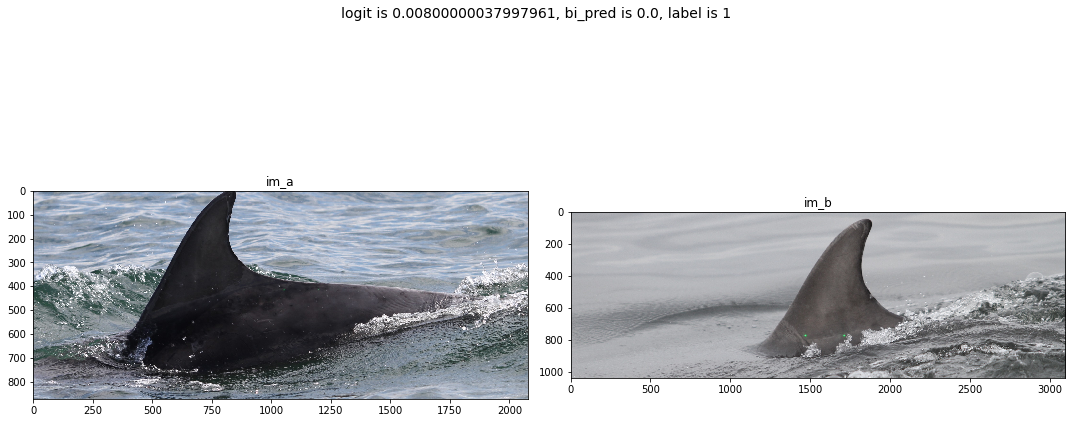

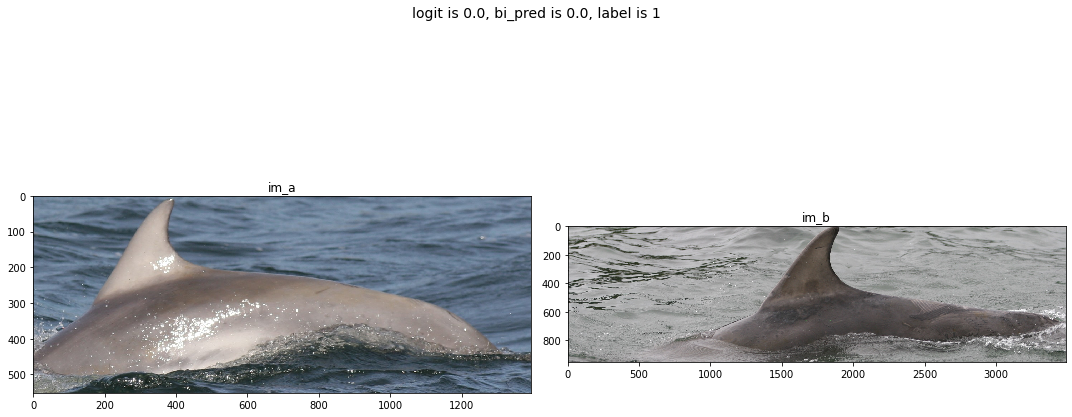

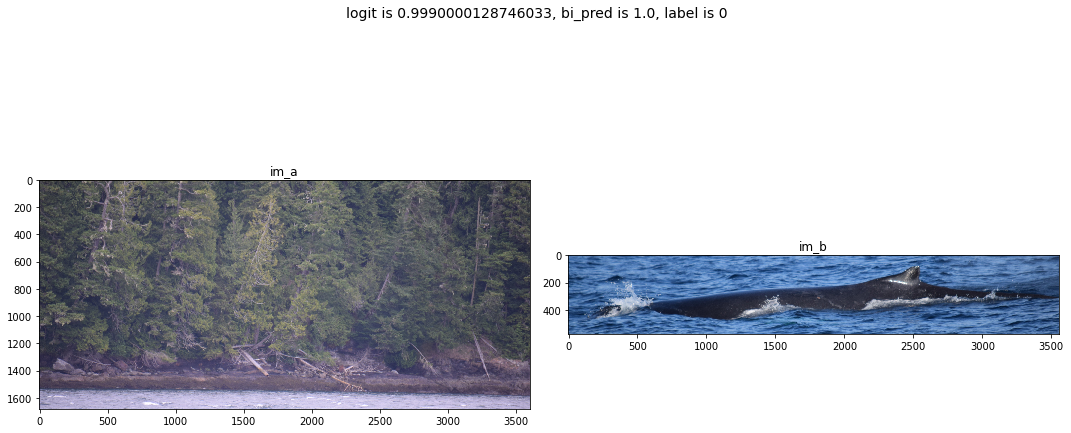

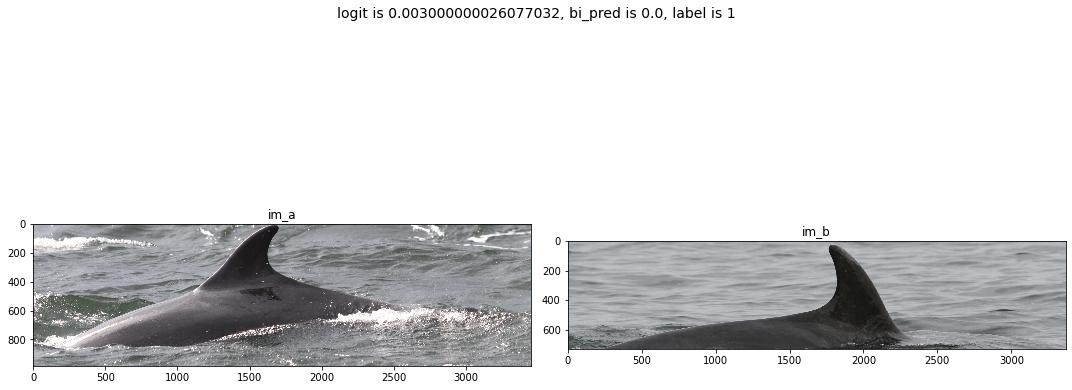

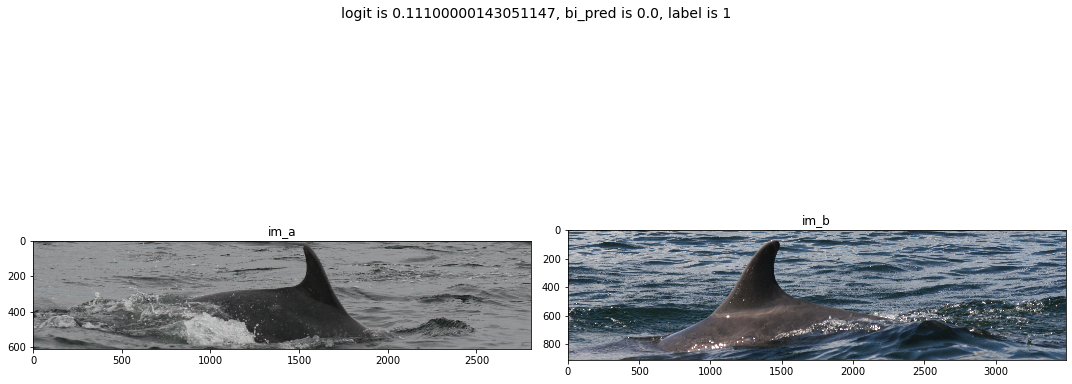

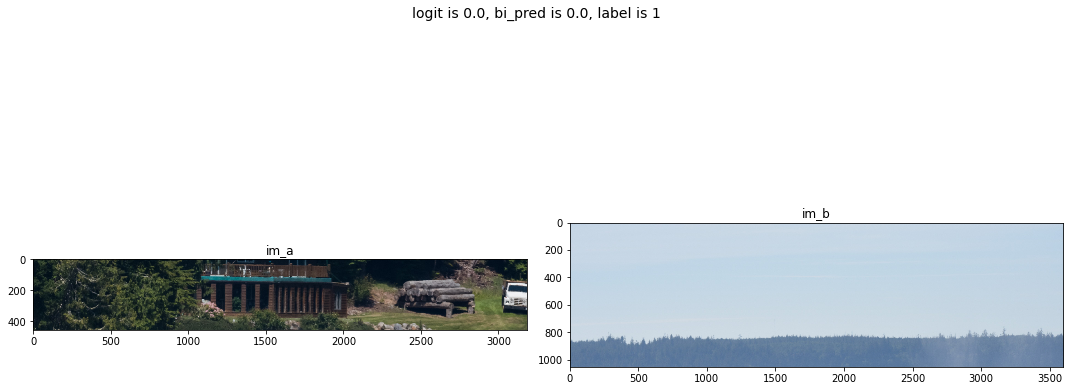

In [61]:
for idx in random.sample(range(0, len(top_ids_df)), 10):
    
    row = top_ids_df.iloc[idx]
    im_a, im_b = get_input(row)
    bi_pred = row.bi_preds
    logit = row.logits
    logit = round(logit, 3)
    label = row.label
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
    st = fig.suptitle(f"logit is {logit}, bi_pred is {bi_pred}, label is {label}", fontsize=14)

    ax1.imshow(im_a, interpolation='nearest')
    ax1.title.set_text('im_a')

    ax2.imshow(im_b, interpolation='nearest')
    ax2.title.set_text('im_b')

    fig.tight_layout(rect=[0, 0.50, 1, 0.95])
    plt.show()